# Pursuit Evasion game with deep reinforcement Learning (DDPG)

A pursuite evasion game (PEG) is dynamic game between two robots or agents, named the pursuer **p** and evader **e**.  
- **p** tries to catch the evader agent **e** as quickly as possible. 
- **e** on the other tries to avoid capture or at least delay it as long as possible.   

Both agents react to each others actions and try to complete optimal actions to achive their goals.  
This work served as preperation for my master thesis and explore the use of Deep Deterministic Policy Gradient (DDPG) for similar problems.  
At the time of this work, DDPG is considered a state of the art deep reinforcement Learning algorithm adapted for problems / games with continuous action domain, such as robotics.  
In Robotics, a kinematic model describes the motion of the robot given its linear and angular velocities.  In other words, we command velocities to reach a defined position.  
It's a continous action domain, since the velocity is a physical variable that belongs to a continuous interval **[Vmin, Vmax]**.

In this work, we will use DDPG to train a pursuer with the goal to catch an evader that has random actions. Both agents have constant speeds but variable angular velocities (steering). **p** will have a speed advantage and **e** will have a steering advantage.

A nice implementation of DDPG is offered on Keras Website :
https://keras.io/examples/rl/ddpg_pendulum/

The main work here is to :
- Define Observations
- Define the transition or step function
- Define a reward model
- Adapt the DDPG model to the problem
- Define the algorithm that trains the pursuer to complete its Goal.
- Evaluate the results

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Overview of Deep Reinforcement Learning and DDPG

The DDPG algorithm is based on an Actor-Critic architecture.
- The actor network take as input the state ***s*** of the game (enviorement) and produces an action ***a***.
- The Critic network, take the actor's action and the state and enviorement ***(s, a)*** and estimates the action-value ***Q(s,a)*** 
The agent executes the action ***a***, so we obtain a new state ***s'*** and the agent recieves a reward ***r***.

In reinforcement learning, ***Q(s,a)*** can be described also by :
***Q(s,a) = r + Q(s',a')*** 

So DDPG uses another actor-critic architecture called taget actor-acritic, where :
- the target actor takes ***s'*** and outputs ***a'***
- the target critic takes ***(s', a')*** to output ***Q(s',a')***

In practice the two target networks will not be trained but will be softly updated from the parameters of the main actor critic network.

In [2]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

### Experience replay

The experience replay buffer is a valuable tool that helps the training to converge. We will store every transion ***(s,a,r,s')*** in a memory (Buffer) and later train the algoritm on a random sample of this buffer.  
In this way we avoid training the agent on the last transitions, which if are bad, can make the learning diverge or get stuck in a local optima. Also this approach encourages exploration.

In [3]:
class P_Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = p_target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * p_target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = p_critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, p_critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, p_critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = p_actor_model(state_batch, training=True)
            critic_value = p_critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, p_actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, p_actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

## Actor & critic

Here we define the neural networks for the actor and critic.
Given that the actor is providing the action for angular velocity, and since this value can be positive or negative, we use **tanh** as activation function since it outputs values in [-1,1]. we then multiply the output by the maximal allowed angular velocity.
The critic on the other hand can give any real output.

In [4]:
def get_actor(max_angle_velocity):
    # Initialize weights
    last_init = tf.random_uniform_initializer(minval=-.001, maxval=.001)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 22.5.
    outputs = outputs * max_angle_velocity
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

## Policy Function

In order t improve the robustness of the algorithm, we add some noise to the selected action, but we have to ensure that angular velocity is always in [-Vmax, Vmax].
The policy action takes care of all that and outputs only *legal actions"

In [5]:
def p_policy(state, noise_object):
    sampled_actions = tf.squeeze(p_actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -p_max_angle_velocity, p_max_angle_velocity)

    return [np.squeeze(legal_action)]

# ***Enviorement modeling***

### Observation  or enviorement state

In every step of this game, every robot can be described by its position and orientation, we will then choose as state descriptiono the positions and orientations of both robots  
s = ($x_{p},y_{p}, \theta_{p}, x_{e}, y_{e},\theta_{e}$)

### Distance Function

We will need to compute the euclidean distance between the robots

In [6]:
def dist(x1,y1,x2,y2):
    d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return d

## Reset Environnement

After every episode, either success or failure, we will need to reset the enviorement, bringing both robots to their initial state, in order to restart the game

In [7]:
def reset_evt(random = False): 
    # init p
    xp, yp, theta_p= (1.0, 1.0, -np.pi/4)

    xe, ye, theta_e = (10.0, 5.0, np.pi/4)

    vp = 4.0
    ve = 3.0
    
    observation = (xp, yp, theta_p, xe, ye, theta_e)
    
    d = dist(xp, yp, xe, ye)
    
    return observation, vp, ve, d

## Reward Function

One crucial step is to design the reward function.   
As our algorithm tries to maximize its gains, we will take as reward the negative of the distance between the two agents. In that way, the algorithm will try to reach **d=0**, which allows our pursuer to catch the evader.  
As explained in introduction, the pursuer need to that as quick as possible, so we add a step penalty of **-10**, to encourage the agent to reduce the number of steps.  
If a capture happens, the pursuer recives a high positive reward.

In [8]:
def R(d, d_min):
    if d < d_min:
        done = True
        reward = 100.0
    else:
        done = False
        reward = -d -10 # -10 for every additional step
    return reward, done    

## Transtion function (step Function)

The trasition function is the kinematic model of a simple non-holonomic mobile robot.  
In each step, new positions and orientations are computed from the previous observation and the velocities of the robots.
The function will also test if the robot reached ***$d_{min}$*** which is the distance where we consider a capture has occured.  
The capture will return :
- The new state / observation ***s'***
- The related reward ***r***
- ***done*** a boolean variable for capture
- The new distance


In [9]:
def transition(observation, action_p, action_e, vp, ve, previous_d, sampling_time, d_min = .3):
    xp, yp, theta_p, xe, ye, theta_e = observation
    d_theta_p = action_p
    d_theta_e = action_e
   
    # updae angles
    theta_p += np.deg2rad(d_theta_p)
    theta_e += np.deg2rad(d_theta_e)
    
    # updtate p position
    xp_new = xp + vp * np.cos(theta_p) * sampling_time
    yp_new = yp + vp * np.sin(theta_p) * sampling_time
    
    # updtate e position
    xe_new = xe +ve * np.cos(theta_e) * sampling_time
    ye_new = ye +ve * np.sin(theta_e) * sampling_time
    
    observation_new = (*xp_new, *yp_new, *theta_p, xe_new, ye_new, theta_e)
    #observation_new = (xp_new, yp_new, theta_p, xe_new, ye_new, theta_e)
    #print(observation_new)
    
    d = np.sqrt((xp - xe)**2 + (yp - ye)**2)
    
    reward, done = R(d, d_min)
    
    return (observation_new, reward, done, d)

## Initialisation before training

Here we intialize a variety of hyper parameters, either for the neural networks or for the robot charcteristics.
We initialize also our agent and the experience replay buffer

In [10]:
np.random.seed(0)

## Game and robots characteristics
num_states = 6
p_max_angle_velocity = 45
e_max_angle_velocity = 60.0

sampling_time = 0.1

num_actions = 1
d_min=4

# noise for pursuer
std_dev = 0.2
p_ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

########################
## Pursuer DDPG model ##
########################
p_actor_model = get_actor(p_max_angle_velocity)
p_critic_model = get_critic()

p_target_actor = get_actor(p_max_angle_velocity)
p_target_critic = get_critic()

# Making the weights equal initially
p_target_actor.set_weights(p_actor_model.get_weights())
p_target_critic.set_weights(p_critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

# Optimizers for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Discount factor for future rewards
gamma = 0.99
# Used to soft-update target networks
tau = 0.005

# init Buffer
p_buffer = P_Buffer(50000, 64)

####################################, steps
# nb of episode########, steps and score tracking
total_episodes = 1000
nb_steps = 200
best_ep_score =  -float("inf")
best_avg_score =  -float("inf")

## Training algorithm

Episode : 0 | success False | Ep Reward :  -6249.4 | Avg Reward :  -6249.4  | game duration = 20.0s


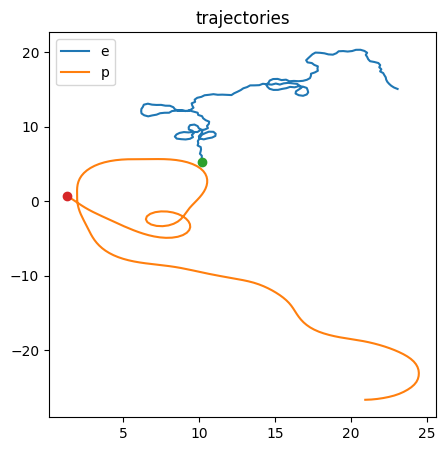

Episode : 100 | success False | Ep Reward :  -4137.3 | Avg Reward :  -4336.4  | game duration = 20.0s


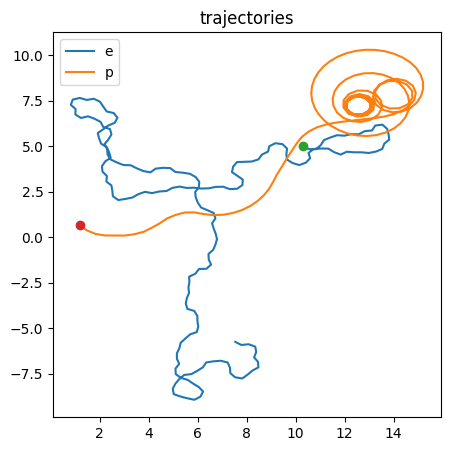

Episode : 200 | success True | Ep Reward :  -2422.0 | Avg Reward :  -3764.0  | game duration = 15.200000000000001s


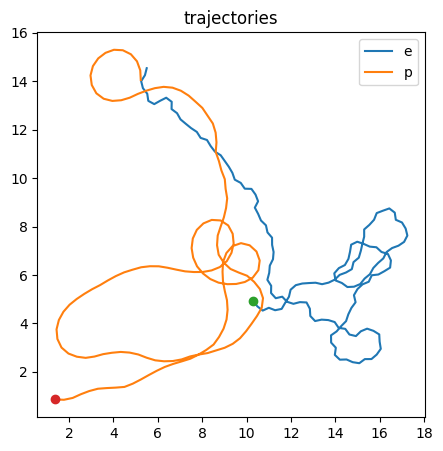

Episode : 300 | success False | Ep Reward :  -4006.6 | Avg Reward :  -4088.1  | game duration = 20.0s


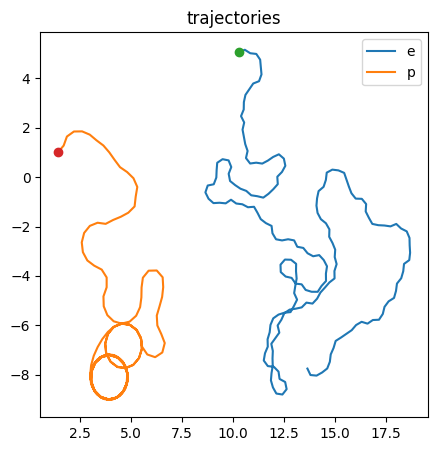

Episode : 400 | success False | Ep Reward :  -3977.7 | Avg Reward :  -3379.4  | game duration = 20.0s


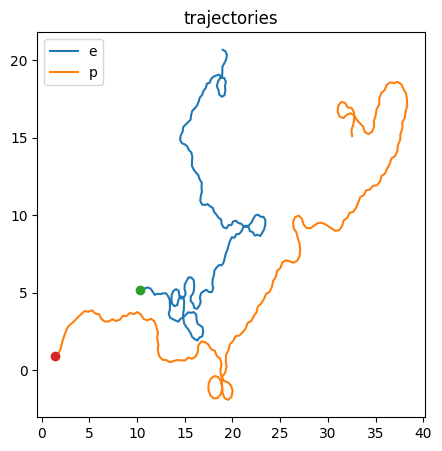

Episode : 500 | success False | Ep Reward :  -3730.6 | Avg Reward :  -3535.7  | game duration = 20.0s


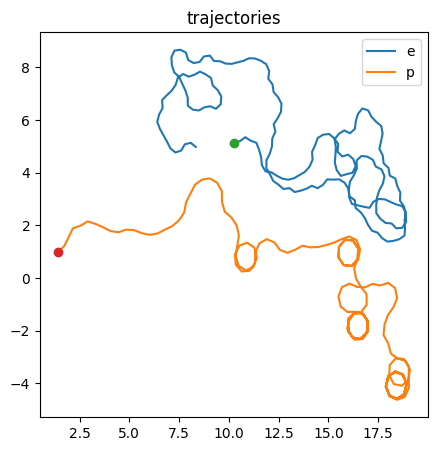

Episode : 600 | success True | Ep Reward :  -472.3 | Avg Reward :  -2689.2  | game duration = 3.7s


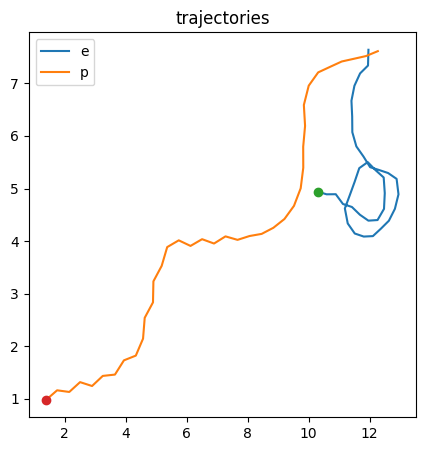

Episode : 700 | success False | Ep Reward :  -3606.7 | Avg Reward :  -3086.2  | game duration = 20.0s


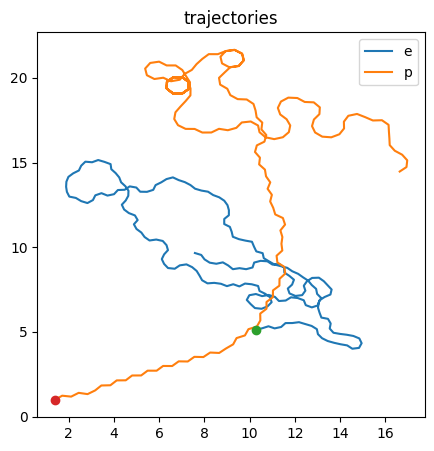

Episode : 800 | success False | Ep Reward :  -5542.4 | Avg Reward :  -2875.3  | game duration = 20.0s


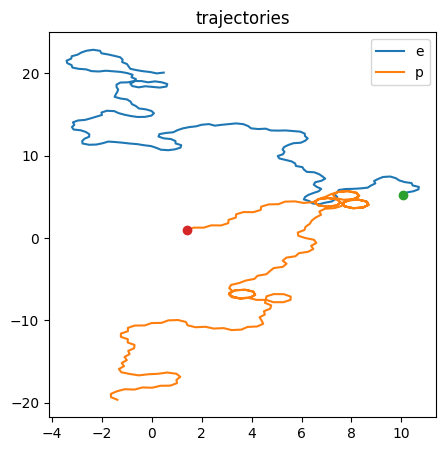

Episode : 900 | success False | Ep Reward :  -3836.5 | Avg Reward :  -2975.8  | game duration = 20.0s


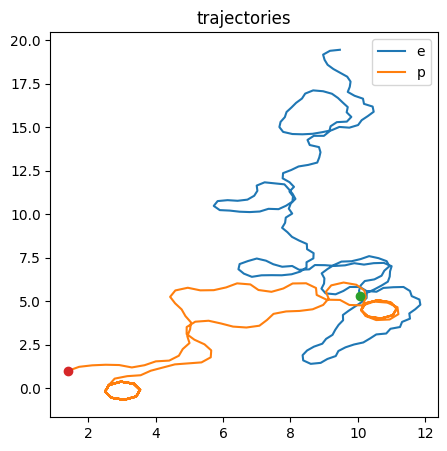

Episode : 959 | success True | Ep Reward :  -470.2 | Avg Reward :  -3010.0  | game duration = 3.5s


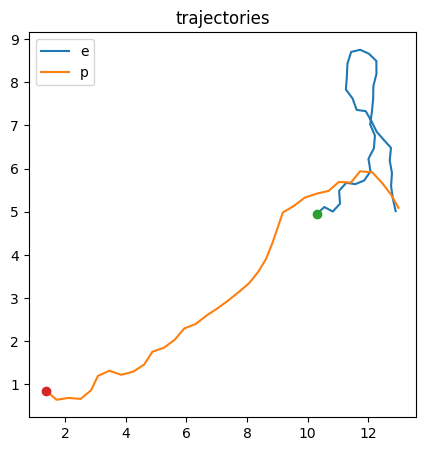

Episode : 962 | success True | Ep Reward :  -370.3 | Avg Reward :  -2937.4  | game duration = 3.1s


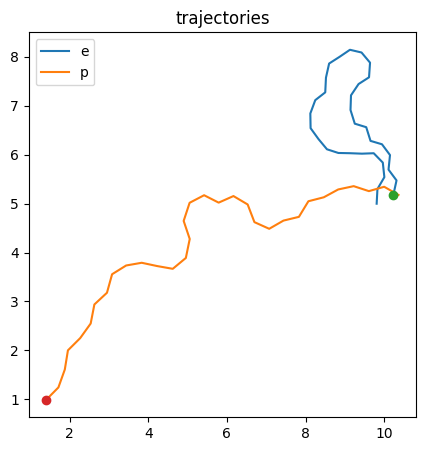

Episode : 964 | success True | Ep Reward :  -539.4 | Avg Reward :  -2897.0  | game duration = 4.800000000000001s


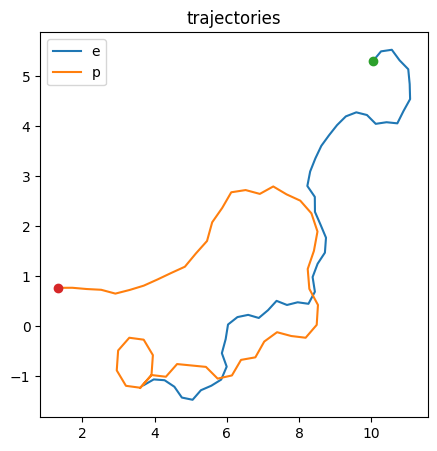

Episode : 966 | success True | Ep Reward :  -658.0 | Avg Reward :  -2880.0  | game duration = 5.2s


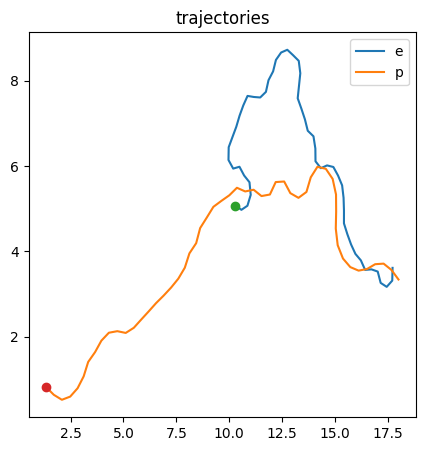

Episode : 968 | success True | Ep Reward :  -1838.4 | Avg Reward :  -2830.2  | game duration = 14.4s


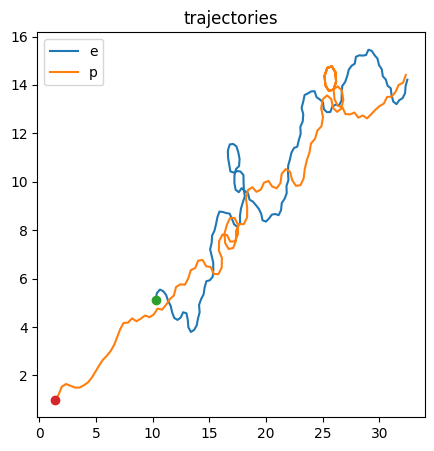

Episode : 970 | success True | Ep Reward :  -1037.8 | Avg Reward :  -2824.4  | game duration = 8.4s


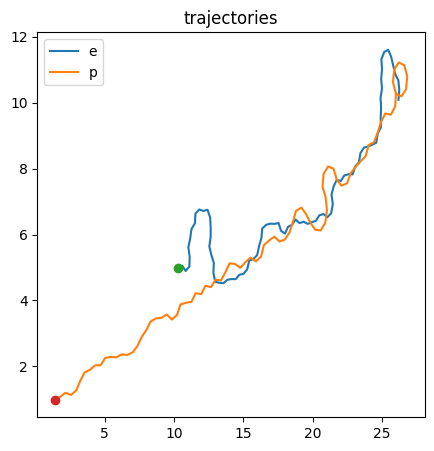

Episode : 972 | success True | Ep Reward :  -516.5 | Avg Reward :  -2817.4  | game duration = 3.9000000000000004s


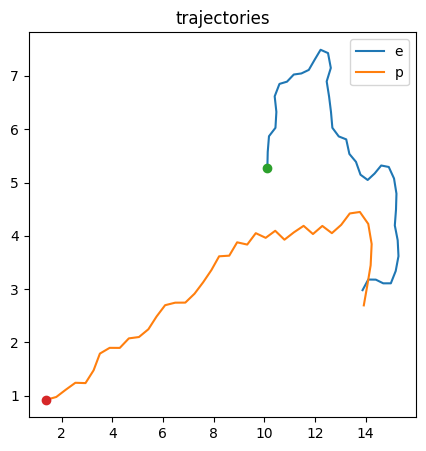

Episode : 974 | success True | Ep Reward :  -881.6 | Avg Reward :  -2797.0  | game duration = 7.0s


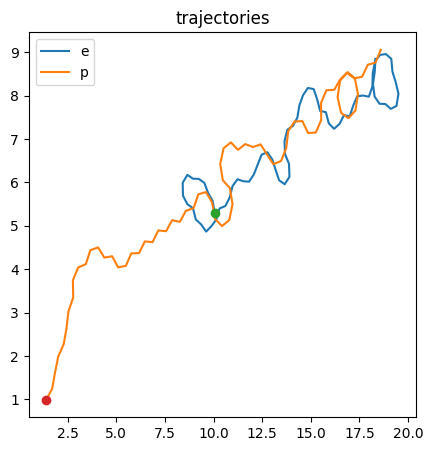

Episode : 978 | success True | Ep Reward :  -609.4 | Avg Reward :  -2795.6  | game duration = 5.2s


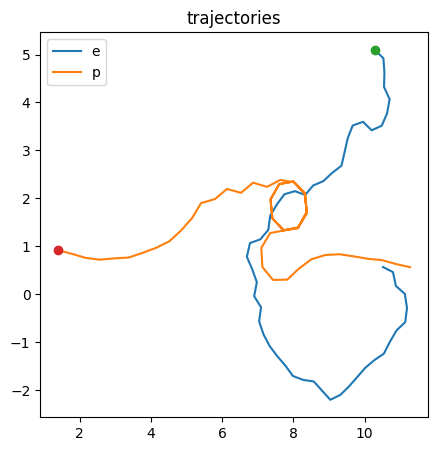

Episode : 982 | success True | Ep Reward :  -406.1 | Avg Reward :  -2728.2  | game duration = 3.3000000000000003s


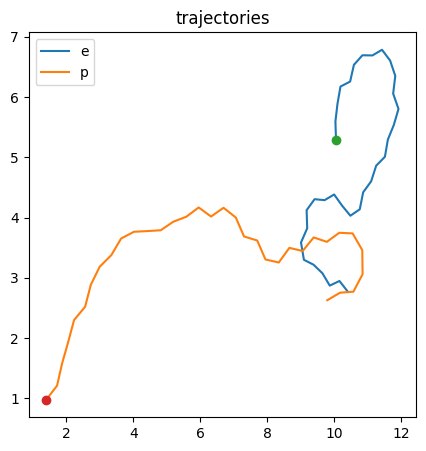

Episode : 989 | success True | Ep Reward :  -564.3 | Avg Reward :  -2826.3  | game duration = 4.0s


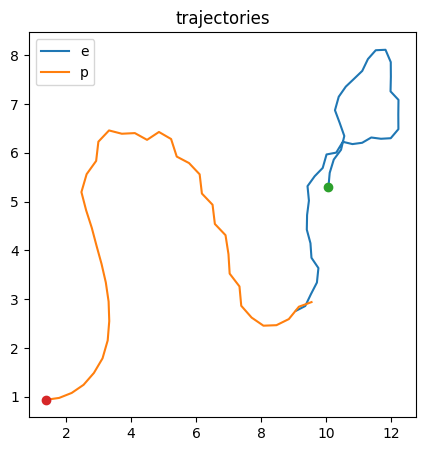

Episode : 997 | success True | Ep Reward :  -1148.6 | Avg Reward :  -2898.8  | game duration = 7.5s


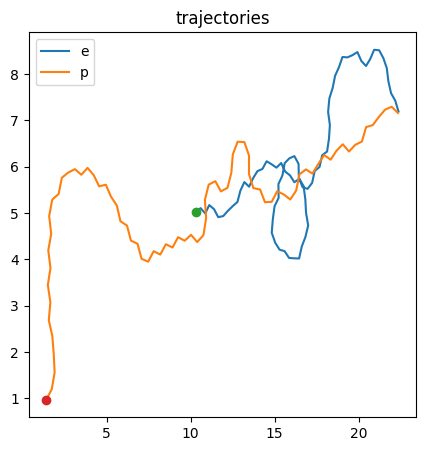

Episode : 999 | success True | Ep Reward :  -711.9 | Avg Reward :  -2794.6  | game duration = 4.7s


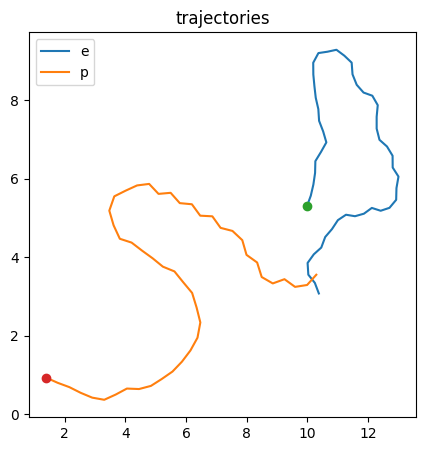

In [11]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

for ep in range(total_episodes):
    # reset enviorement
    prev_state, vp, ve, previous_d = reset_evt()
    
    # init tracking parameters
    episodic_reward = 0
    capt_time = None
    step = 0
    
    # init trajectory vectors
    xp_pos = []
    yp_pos = []
    xe_pos = []
    ye_pos = []
    act_ep = []

    while True:
        
        # select actionfor p from actor and format it from tensorflow to numpy
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action_p = p_policy(tf_prev_state, p_ou_noise)
        # store action
        act_ep.append(action_p)
        
        #generate random action for e
        action_e = np.random.uniform(-60.0,60.0)
        
        # Recieve state and reward from environment.
        state, reward, done, previous_d = transition(prev_state, action_p, 
                                                     action_e,vp, ve, previous_d, sampling_time)
        # store transition
        p_buffer.record((prev_state, action_p, reward, state))
        
        # track episode reward
        episodic_reward += reward
        
        # learning
        p_buffer.learn()
        # Target networks update
        update_target(p_target_actor.variables, p_actor_model.variables, tau)
        update_target(p_target_critic.variables, p_critic_model.variables, tau)
        
        # store new positions
        xp_pos.append(state[0])
        yp_pos.append(state[1])
        xe_pos.append(state[3])
        ye_pos.append(state[4])
        
        # End this episode when `done` is True
        if done:
            capt_time= step * sampling_time
            break
        
        # end episode when nb_steps reached
        step+=1
        if step >=nb_steps:
            break
        
        # store new state in prev state for the next iteration
        prev_state = state
        
    # store score of the episode
    ep_reward_list.append(episodic_reward)

    # Mean of last 50 episodes
    avg_reward = np.mean(ep_reward_list[-50:])
    avg_reward_list.append(avg_reward)
    
    # saving agent with best score
    if episodic_reward > best_ep_score and done:
        p_actor_model.save_weights("./myddpg/pursuer_best_actor.h5")
        best_ep_score = episodic_reward
        # track best episode
        best_model_ep = ep

    if avg_reward > best_avg_score and done:
        p_actor_model.save_weights("./myddpg/pursuer_best_avg_actor.h5")
        best_avg_score = avg_reward
        # track episode with best avg score
        best_avg_model_ep = ep
        
    # episode summary  
    log_ep = [ep, done*1, np.round(episodic_reward), capt_time, step+1, np.round((step+1)*sampling_time)]
    
    if ep ==0:
        log_df = pd.DataFrame(log_ep).T
    else:
        log_df = pd.concat([log_df, pd.DataFrame(log_ep).T], axis=0, ignore_index=True)
    
 
    # plot every 100x episode, then the best best episodes in the last 50
    if (ep % 100 == 0) or (ep > 950 and done):
        print("Episode : {} | success {} | Ep Reward :  {} | Avg Reward :  {}  | game duration = {}s".format(
            ep, done, np.round(episodic_reward,1), np.round(avg_reward,1),  step*sampling_time))
        plt.figure(figsize =(5, 5,))
        plt.plot(xe_pos, ye_pos, label='e')
        plt.plot(xp_pos, yp_pos, label='p')
        plt.plot(xe_pos[0],ye_pos[0],'o')
        plt.plot(xp_pos[0],yp_pos[0],'o')
        plt.legend()
        plt.title('trajectories')
        plt.show()


We can see from above, as the pursuer behavior is improving form through training.

# Interpretation

Overall the model has worked and the agent is able to react to random evader.  
A way of judging peformance is by looking at the evolution of the game score.  
We notice that results vraies drastically from an episode to another, but seeing the moving average, overall the agent is improving.  
Also we notice drops in performanceat about 300 and 500 episodes, which unfortunately a charcteristic of acrtor-critic algorithms, as they diverge from time to time.

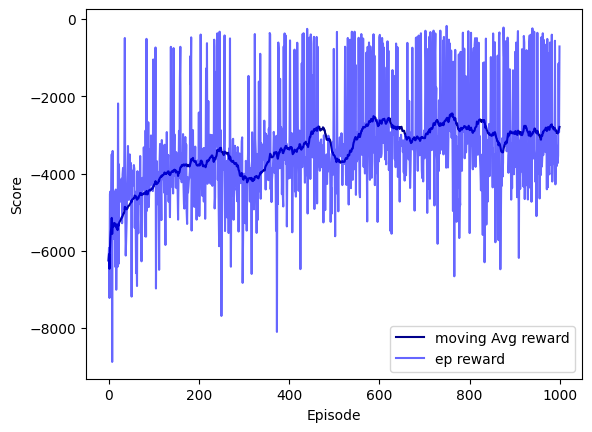

In [50]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list, color= 'darkblue', label='moving Avg reward')
plt.plot(ep_reward_list, '-b', alpha=0.6, label='ep reward')
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.show()

We can determin the best episodes and thus the best agents, but this is not always true.  
In our case the evader is moving randomly, so it is possible that it headed directly into the pursuer. In it may be safer to take the one with the best Avg score, or visualize the episode to be sure it was normal.

In [19]:
print ("The actor with the best score: ", best_model_ep, 'with a score of: ' )
print ("The actor with the best average score: " ,best_avg_model_ep)

The actor with the best score:  749
The actor with the best average score:  759


Another way to visualise performance is by following the number of successes, in that matter we see below that the pusuer in continually improving, and has a higher success rate in the end.

In [ ]:
log_df.columns = ['episode','success', 'ep_reward', 'capt_time', 'Steps','duration']

<Axes: >

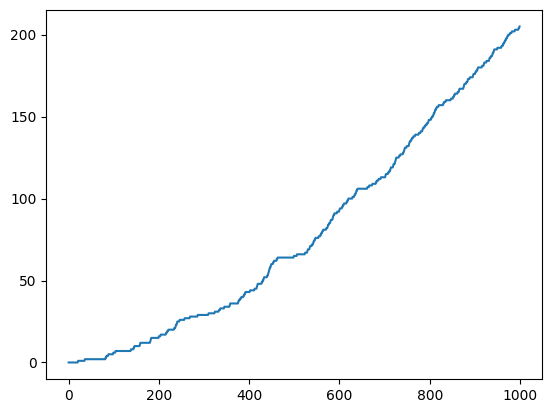

In [28]:
log_df['cumul_wins'] = log_df['success'].cumsum()
log_df['cumul_wins'].plot()

We can also follow the capture time. In the following plots we can see that the capture time become less spread as we approach the end of training, but some high capture times can still happen even in thed of training.  
We can se also that the mean capture time is in about 7s, but it is about 5.5 s at the end of training.

mean capture time:  6.9175609756097565
mean capture time in the last 100 ep:  5.5103448275862075


<Axes: >

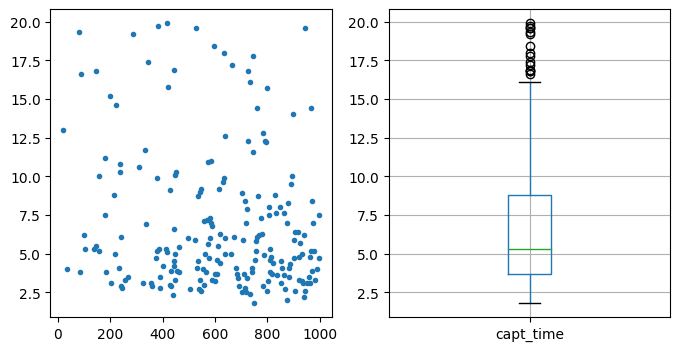

In [60]:
print('mean capture time: ', log_df['capt_time'].mean())
print('mean capture time in the last 100 ep: ', log_df['capt_time'].iloc[-100:].mean())
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
log_df['capt_time'].plot(marker='.', linestyle='none', ax = ax1)
log_df.boxplot(column='capt_time', ax=ax2)

# Conclusion

The aim of this work is to explore the use of Deep Reinforcement learning robots motion control in a pursuit evasion Problem.  
We chose to use DDPG as it is suited for continuous action domain problems.  
We worked on an easy case of a pursuer having a speed advantage over the evader, but lower agility.  
We Focused mainly on the pursuer and we chose to work on a random evader.  
As models are generally provided in tensorflow or pytorch, we focused on adapting the model to the task and in to building the main elements of a RL problem :
- Enviorement and state
- Transition function
- Reward Function
- Training Algorithm.

Overall results were staisfying, as the pursuer learns to track evader and improve its capture time. Determining the best model remains a problem to solve as relying only on score is not possible in this case.